# Training the SPOCK model

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt

from hadden_theory.test_particle_secular_hamiltonian import SyntheticSecularTheory, TestParticleSecularHamiltonian, calc_g0_and_s0
from hadden_theory import test_particle_secular_hamiltonian
# hack to make pickle load work
import sys
sys.modules['test_particle_secular_hamiltonian'] = test_particle_secular_hamiltonian

try:
	plt.style.use('/Users/dtamayo/.matplotlib/paper.mplstyle')
except:
	pass

ImportError: cannot import name 'PoissonSeriesHamiltonian' from 'celmech.poisson_series' (/home/miniconda3/envs/lshen/lib/python3.12/site-packages/celmech/poisson_series.py)

In [ ]:
import pickle
with open("hadden_theory/solar_system_synthetic_solution.bin","rb") as fi:
	solar_system_synthetic_theory=pickle.load(fi)

In [ ]:
truncate_dictionary = lambda d,tol: {key:val for key,val in d.items() if np.abs(val)>tol}
simpler_secular_theory = SyntheticSecularTheory(
	solar_system_synthetic_theory.masses,
	solar_system_synthetic_theory.semi_major_axes,
	solar_system_synthetic_theory.omega_vector,
	[truncate_dictionary(x_d,1e-3) for x_d in solar_system_synthetic_theory.x_dicts],
	[truncate_dictionary(y_d,1e-3) for y_d in solar_system_synthetic_theory.y_dicts]
)

In [ ]:
# Read the table with the defined column specifications
df = pd.read_fwf('MPCORB.DAT', colspecs=[[0,7], [8,14], [15,19], [20,25], [26,35], [36,46], [47, 57], [58,68], [69,81], [82, 91], [92, 103]])
df = df[df['Epoch'] == 'K239D'] # take only ones at common epoch--almost all of them
for c in ['a', 'e', 'Incl.', 'Node', 'Peri.', 'M']:
	df[c] = pd.to_numeric(df[c])
df.head()

,Des'n,H,G,Epoch,M,Peri.,Node,Incl.,e,n,a
1,00001,3.34,0.15,K239D,60.07879,73.42179,80.25496,10.58688,0.078913,.21410680,2.767254
2,00002,4.12,0.15,K239D,40.59806,310.87290,172.91881,34.92584,0.230229,.21377378,2.770128
3,00003,5.17,0.15,K239D,37.02310,247.73791,169.83920,12.99055,0.256213,.22600445,2.669263
4,00004,3.22,0.15,K239D,169.35183,151.66223,103.71002,7.14218,0.089449,.27152244,2.361922
5,00005,7.00,0.15,K239D,303.39802,359.13666,141.46909,5.35867,0.187439,.23826556,2.576886


evectors, ivectors
relative to the planet
add variance of a, res osc will shift sec

In [ ]:
labels = pd.read_fwf('proper_catalog24.dat', colspecs=[[0,10], [10,18], [19,28], [29,37], [38, 46], [47,55], [56,66], [67,78], [79,85], [86, 89], [90, 97]], header=None, index_col=False, names=['propa', 'da', 'prope', 'de', 'propsini', 'dsini', 'g', 's', 'H', 'NumOpps', "Des'n"])
labels.head()

,propa,da,prope,de,propsini,dsini,g,s,H,NumOpps,Des'n
0,2.767028,2.300000e-05,0.115193,0.00016,0.167560,0.000013,54.253800,-59.249995,3.34,123,00001
1,2.771276,1.200000e-04,0.280234,0.00034,0.546016,0.000045,-1.372312,-46.451120,4.12,121,00002
2,2.669376,7.500000e-06,0.233600,0.00001,0.229144,0.000003,43.858531,-61.476025,5.17,114,00003
3,2.361512,5.900000e-08,0.099452,0.00014,0.111023,0.000180,36.882605,-39.610314,3.22,110,00004
4,2.577657,2.900000e-05,0.171249,0.01200,0.076113,0.001400,52.506470,-51.132322,7.00,87,00005


In [ ]:
import os
filenames = [f for f in os.listdir("integrations/simulation_files") if os.path.isfile(os.path.join("integrations/simulation_files", f))]
filenames[1][11:16]
Desn = []
for i in range(len(filenames)):
	Desn.append(filenames[i][11:16])

integration_path = Path("integrations/new_ecc_inc_integrations_1")
matched_files = [f for f in integration_path.iterdir() if any(des in f.name for des in Desn)]
rows = []

for i in range(len(matched_files)):
	soln_h = np.load(matched_files[i])
	y = soln_h["y"]
	prope_value = np.average(np.abs((y[9] - 1j * y[0]) / np.sqrt(2)))
	propsini_value = np.average(np.abs((y[1+9] - 1j * y[1]) / np.sqrt(2)))
	des_n = matched_files[i].stem.replace("integration_results_", "")
	rows.append([des_n, prope_value, propsini_value])

df_h = pd.DataFrame(rows, columns=["Des'n", "prope_h", "propsini_h"])

In [ ]:
merged_df = pd.merge(df, labels, on="Des'n", how="inner")
merged_df = pd.merge(merged_df, df_h, on="Des'n", how="inner")
merged_df.shape, labels.shape

((11854, 23), (1249051, 11))

In [ ]:
merged_df["g0"] = merged_df['a'].apply(lambda x: calc_g0_and_s0(x, simpler_secular_theory)[0])

In [ ]:
type(merged_df["g0"][0])

numpy.float64

In [ ]:
merged_df['ecospo'] = merged_df['prope_h']*np.cos((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
merged_df['esinpo'] = merged_df['prope_h']*np.sin((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
merged_df['sinicosO'] = np.sin(merged_df['propsini_h']*np.pi/180)*np.cos(merged_df['Node']*np.pi/180)
merged_df['sinisinO'] = np.sin(merged_df['propsini_h']*np.pi/180)*np.sin(merged_df['Node']*np.pi/180)

In [ ]:
merged_df.to_csv("integrations/merged_elements.csv")

In [4]:
merged_df = pd.read_csv("merged_elements.csv")
merged_df.columns

Index(['Unnamed: 0', 'Des'n', 'H_x', 'G', 'Epoch', 'M', 'Peri.', 'Node',
       'Incl.', 'e', 'n', 'a', 'propa', 'da', 'prope', 'de', 'propsini',
       'dsini', 'g', 's', 'H_y', 'NumOpps', 'prope_h', 'propsini_h', 'g0',
       'ecospo', 'esinpo', 'sinicosO', 'sinisinO'],
      dtype='object')

In [5]:
#features = ['M', 'Peri.', 'Node', 'Incl.', 'e', 'a']
#features = ['M', 'Peri.', 'Node', 'Incl.', 'e', 'propa']
#features = ['M', 'Node', 'Incl.', 'ecospo', 'esinpo', 'propa']
features = ['sinicosO', 'sinisinO', 'ecospo', 'esinpo', 'propa', 'g0', 'prope_h']
data = merged_df[features]
dela = merged_df['propa']-merged_df['a']
dele = merged_df['prope']-merged_df['e']
delsini = merged_df['propsini_h']-np.sin(merged_df['Incl.']*np.pi/180)
delg = merged_df['g0'] - merged_df['g']
s = merged_df['s']

(0.0, 0.5)

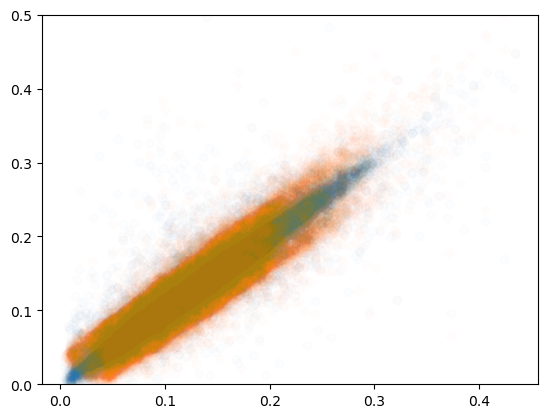

In [6]:
plt.scatter(merged_df['prope'], merged_df['prope_h'], alpha=0.01)
plt.scatter(merged_df['prope'], merged_df['e'], alpha=0.01)
plt.ylim(0, 0.5)

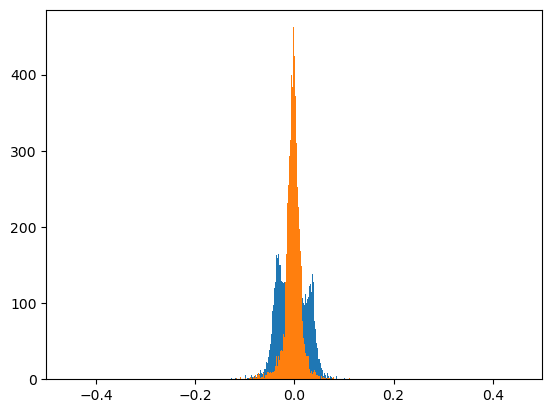

In [7]:
bins = np.linspace(-0.2, 0.2, 1000)
plt.hist(merged_df['prope']-merged_df['e'], bins=bins)
plt.hist(merged_df['prope']-merged_df['prope_h'], bins=bins)
plt.xlim(-0.5, 0.5)
plt.show()

In [8]:
trainX, testX, trainY, testY = train_test_split(data, dele, test_size=0.2, random_state=42)

In [9]:
trainY.shape[0], testY.shape[0]

(23026, 5757)

In [10]:
dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

# Tuning hyperparameter
We will start by creating and testing a collection of models that have randomly selected hyperparameters.
We establish the different parameter space that we will be testing different hyperparameter values within.

In [11]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(40), 1),
	'min_child_weight': hp.loguniform('x_min_child', 0, np.log(30)),
	'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBRegressor(n_estimators = 50,
			    max_depth = int(params['max_depth']), 
			    min_child_weight = params['min_child_weight'],
			    subsample = params['subsample'],
			    learning_rate = 0.15, seed = 0,)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "rmse", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-rmse-mean"])
    error = np.mean(score["test-rmse-std"])
    
    print("SCORE:", avg_score, "+/-", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}


We can now run an array of different parameter combinations

In [12]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 10, trials = trials, rstate=np.random.default_rng(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                                
0.02126575740537073                                   
+/-                                                   
0.0005688627381024404                                 
SCORE:                                                                          
0.021267322296157506                                                            
+/-                                                                             
0.0005763116611923857                                                           
SCORE:                                                                          
0.020665128386399972                                                            
+/-                                                                             
0.0006087410103495239                                                           
SCORE:                                                                          
0.020535679577853065                               

In [27]:
best

{'x_max_depth': 6.0,
 'x_min_child': 29.027212358902943,
 'x_subsample': 0.9458899808537233}

In [28]:
model = XGBRegressor(learning_rate = 0.05, 
						 max_depth = 6, 
						 subsample = 0.946,
						 min_child_weight = 29.03)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "rmse", verbose_eval=True, num_boost_round=500)

[0]	train-rmse:0.03075+0.00012	test-rmse:0.03076+0.00046
[1]	train-rmse:0.02972+0.00011	test-rmse:0.02975+0.00048
[2]	train-rmse:0.02875+0.00012	test-rmse:0.02880+0.00049


[3]	train-rmse:0.02784+0.00012	test-rmse:0.02790+0.00050
[4]	train-rmse:0.02700+0.00012	test-rmse:0.02708+0.00051
[4]	train-rmse:0.02700+0.00012	test-rmse:0.02708+0.00051
[5]	train-rmse:0.02620+0.00012	test-rmse:0.02630+0.00052
[6]	train-rmse:0.02546+0.00013	test-rmse:0.02558+0.00053
[7]	train-rmse:0.02477+0.00013	test-rmse:0.02490+0.00054
[8]	train-rmse:0.02413+0.00014	test-rmse:0.02428+0.00054
[9]	train-rmse:0.02352+0.00014	test-rmse:0.02369+0.00056
[10]	train-rmse:0.02296+0.00014	test-rmse:0.02315+0.00057
[11]	train-rmse:0.02244+0.00014	test-rmse:0.02265+0.00058
[12]	train-rmse:0.02195+0.00014	test-rmse:0.02217+0.00059
[13]	train-rmse:0.02150+0.00015	test-rmse:0.02174+0.00059
[14]	train-rmse:0.02107+0.00015	test-rmse:0.02134+0.00060
[15]	train-rmse:0.02068+0.00015	test-rmse:0.02096+0.00061
[16]	train-rmse:0.02032+0.00015	test-rmse:0.02062+0.00062
[17]	train-rmse:0.01998+0.00015	test-rmse:0.02030+0.00062
[18]	train-rmse:0.01966+0.00016	test-rmse:0.02000+0.00063
[19]	train-rmse:0.0193

# n_estimators (number of trees) tuning

In [29]:
#model.set_params(n_estimators = 10, max_depth = int(best['x_max_depth']), subsample = best['x_subsample'], min_child_weight = best['x_min_child'])
model= xgb.train(dtrain=dtrain, params=model.get_params(), num_boost_round=2000)

pred = model.predict(dtest)

/home/miniconda3/envs/lshen/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:23:15] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "enable_categorical", "missing" } are not used.

  warnings.warn(smsg, UserWarning)


In [30]:
test_indices = testX. index
e_nesvorny_test = merged_df. loc [test_indices, 'prope']
e_initial_test = merged_df. loc[test_indices, 'e']
e_linear_test = merged_df. loc[test_indices, 'prope_h']

rms_nesvorny_vs_initial = np.sqrt(np.median((e_nesvorny_test - e_initial_test)**2))
rms_nesvorny_vs_linear = np. sqrt(np.median((e_nesvorny_test - e_linear_test)**2))
rms_nesvorny_vs_ml=np.sqrt(np.median((testY-pred)**2))
improvement_linear_vs_initial = ((rms_nesvorny_vs_initial - rms_nesvorny_vs_linear) / rms_nesvorny_vs_initial) * 100
improvement_ml_vs_initial = ((rms_nesvorny_vs_initial - rms_nesvorny_vs_ml) / rms_nesvorny_vs_initial) * 100
improvement_ml_vs_linear = ((rms_nesvorny_vs_linear - rms_nesvorny_vs_ml) / rms_nesvorny_vs_linear) * 100
results = {
	'rms_nesvorny_vs_initial': rms_nesvorny_vs_initial,
	'rms_nesvorny_vs_linear': rms_nesvorny_vs_linear,
	'rms_nesvorny_vs_ml': rms_nesvorny_vs_ml,
	'improvement_linear_vs_initial_percent': improvement_linear_vs_initial,
	'improvement_ml_vs_initial_percent': improvement_ml_vs_initial,
	'improvement_ml_vs_linear_percent': improvement_ml_vs_linear
}
results

{'rms_nesvorny_vs_initial': 0.026561699999999994,
 'rms_nesvorny_vs_linear': 0.008288175412035692,
 'rms_nesvorny_vs_ml': 0.0035390448088169074,
 'improvement_linear_vs_initial_percent': 68.79651749686317,
 'improvement_ml_vs_initial_percent': 86.67613590690013,
 'improvement_ml_vs_linear_percent': 57.300073503781356}

Text(0, 0.5, 'CV AUC score')

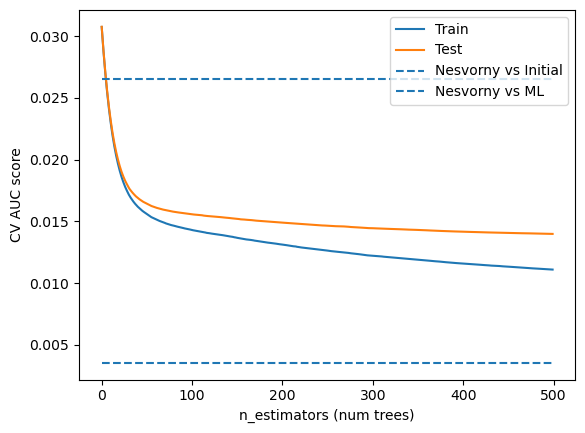

In [31]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
ax.hlines(rms_nesvorny_vs_initial, xmin=score.index.min(), xmax=score.index.max(), linestyle='--', label='Nesvorny vs Initial')
ax.hlines(rms_nesvorny_vs_ml, xmin=score.index.min(), xmax=score.index.max(), linestyle='--', label='Nesvorny vs ML')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

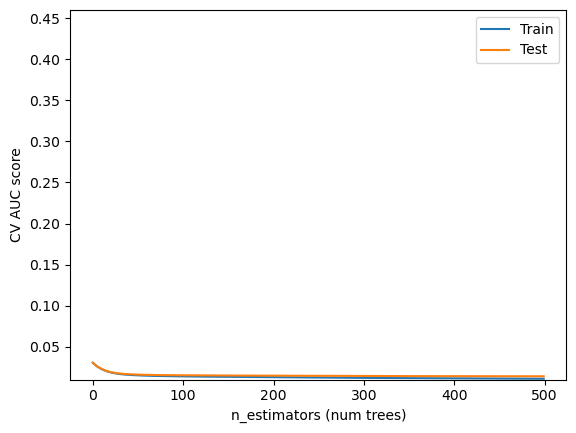

In [19]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
ax.set_ylim(0.01, 0.46)
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

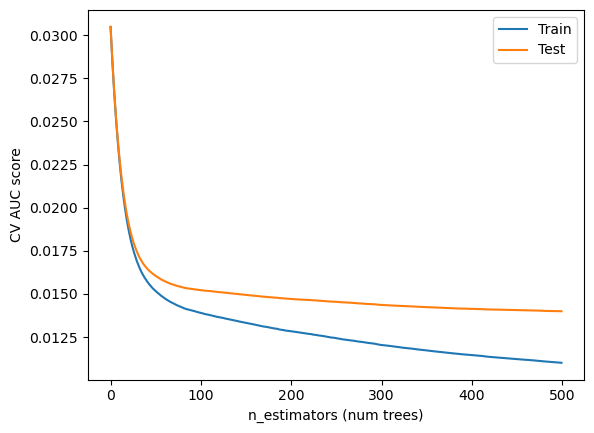

In [20]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

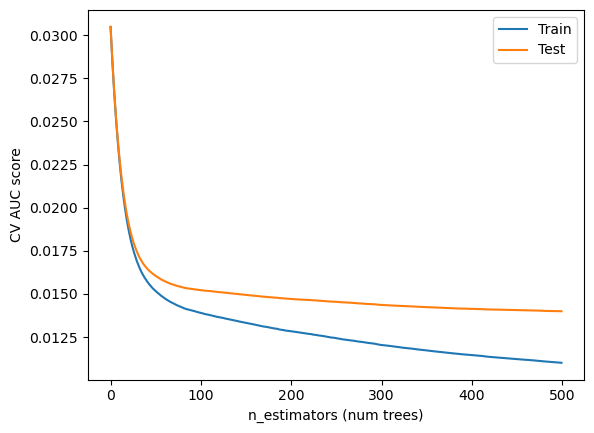

In [22]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

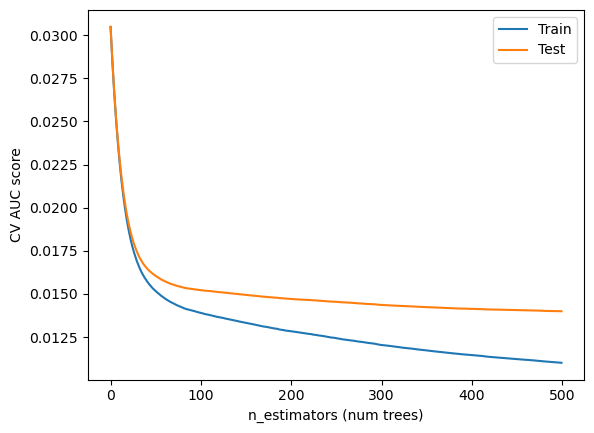

In [23]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

In [24]:
#model.set_params(n_estimators = 10, max_depth = int(best['x_max_depth']), subsample = best['x_subsample'], min_child_weight = best['x_min_child'])
model= xgb.train(dtrain=dtrain, params=model.get_params(), num_boost_round=2000)

AttributeError: 'Booster' object has no attribute 'get_params'

In [25]:
%%time
pred = model.predict(dtest)

CPU times: user 34.4 ms, sys: 1.11 ms, total: 35.5 ms
Wall time: 1.1 ms


In [26]:
np.std(pred-testY)

0.013482646046591199

NameError: name 'labels' is not defined

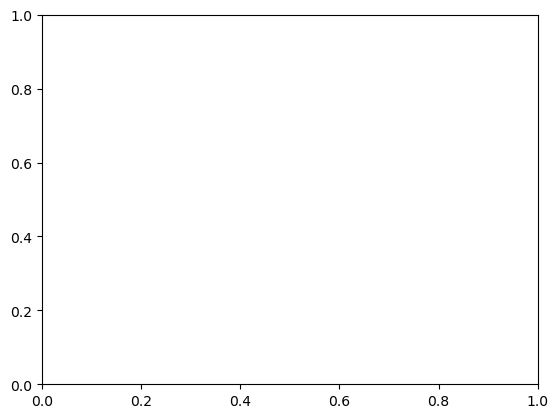

In [32]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(labels['prope'], bins=np.linspace(0, 1, 1000))
ax.set_xlabel('Prop e')

Text(0.5, 0, 'Nesvorny Proper Eccentricity Correction')

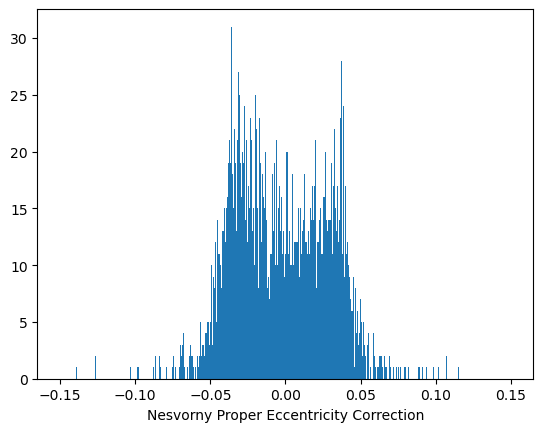

In [28]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(testY, bins=np.linspace(-0.15, 0.15, 1000))
ax.set_xlabel('Nesvorny Proper Eccentricity Correction')

Text(0.5, 0, 'Correction Error (Model-Nesvorny)')

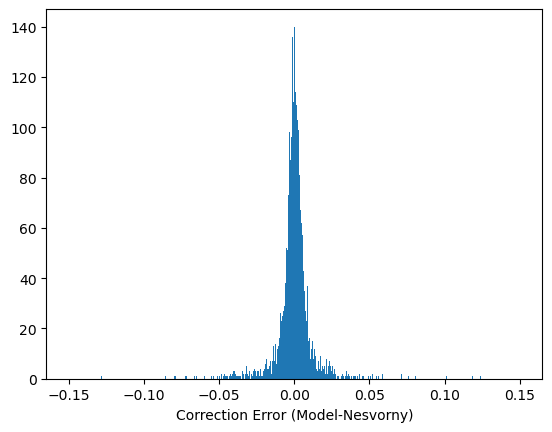

In [ ]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.15, 0.15, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')


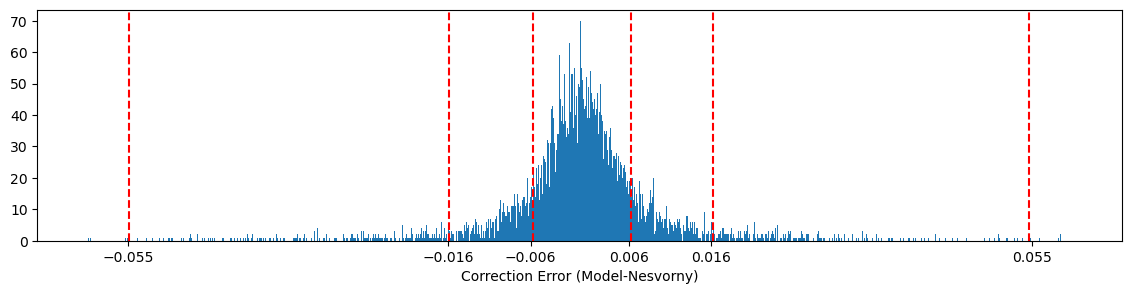

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
	val = np.percentile(pred-testY, p)
	ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

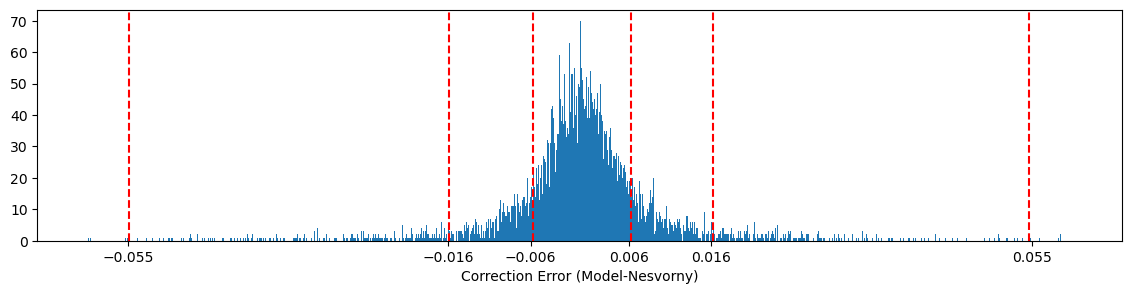

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
	val = np.percentile(pred-testY, p)
	ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

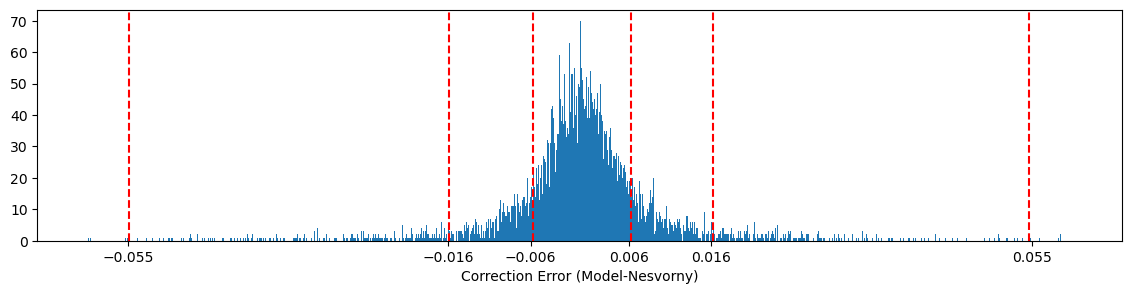

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
	val = np.percentile(pred-testY, p)
	ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

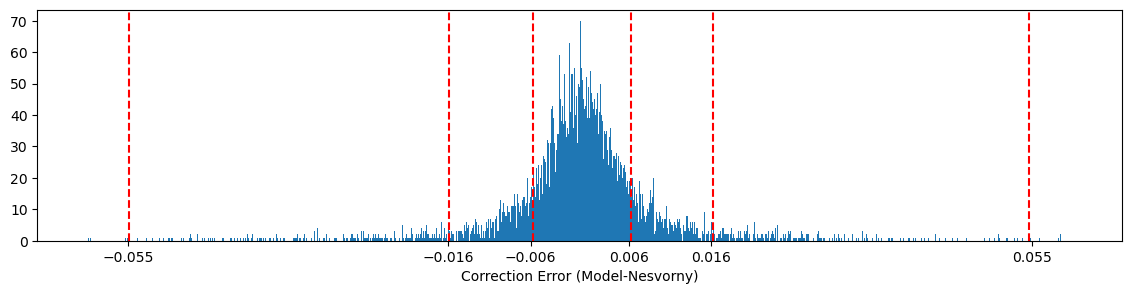

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
	val = np.percentile(pred-testY, p)
	ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

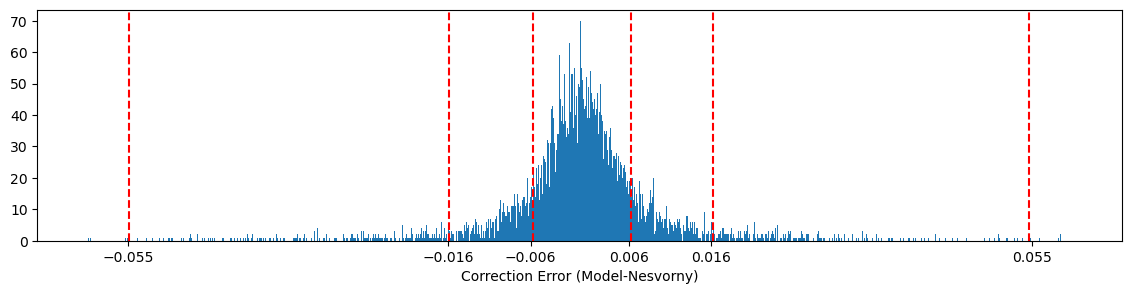

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
	val = np.percentile(pred-testY, p)
	ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

In [26]:
(pred-testY).min()

NameError: name 'pred' is not defined

# RMS Comparison

In [63]:
test_indices = testX. index
e_nesvorny_test = merged_df. loc [test_indices, 'prope']
e_initial_test = merged_df. loc[test_indices, 'e']
e_linear_test = merged_df. loc[test_indices, 'prope_h']

rms_nesvorny_vs_initial = np.sqrt(np.mean((e_nesvorny_test - e_initial_test)**2))
rms_nesvorny_vs_linear = np. sqrt(np.mean((e_nesvorny_test - e_linear_test)**2))
rms_nesvorny_vs_ml=np.sqrt(np.mean((testY-pred)**2))
improvement_linear_vs_initial = ((rms_nesvorny_vs_initial - rms_nesvorny_vs_linear) / rms_nesvorny_vs_initial) * 100
improvement_ml_vs_initial = ((rms_nesvorny_vs_initial - rms_nesvorny_vs_ml) / rms_nesvorny_vs_initial) * 100
improvement_ml_vs_linear = ((rms_nesvorny_vs_linear - rms_nesvorny_vs_ml) / rms_nesvorny_vs_linear) * 100
results = {
	'rms_nesvorny_vs_initial': rms_nesvorny_vs_initial,
	'rms_nesvorny_vs_linear': rms_nesvorny_vs_linear,
	'rms_nesvorny_vs_ml': rms_nesvorny_vs_ml,
	'improvement_linear_vs_initial_percent': improvement_linear_vs_initial,
	'improvement_ml_vs_initial_percent': improvement_ml_vs_initial,
	'improvement_ml_vs_linear_percent': improvement_ml_vs_linear
}
results

{'rms_nesvorny_vs_initial': 0.031893119457800094,
 'rms_nesvorny_vs_linear': 0.025640594867942606,
 'rms_nesvorny_vs_ml': 0.012916321381353861,
 'improvement_linear_vs_initial_percent': 19.60461910328533,
 'improvement_ml_vs_initial_percent': 59.50122910226984,
 'improvement_ml_vs_linear_percent': 49.625500313557026}

# Plots generation

In [34]:
error_threshold = 0.05
nesvorny_vs_ml = np.sqrt((testY-pred)**2)
high_error_mask = nesvorny_vs_ml > error_threshold
high_error_asteroids = merged_df.loc[nesvorny_vs_ml[high_error_mask].index]

In [35]:
import numpy as np
import matplotlib.pyplot as plt

a_jupiter = 5.204
a_mars = 1.524

resonances = {
	"3:1": ("Jupiter", 3, 1),
	"12:5": ("Jupiter", 12, 5),
	"13:5": ("Jupiter", 13, 5),
	"9:4": ("Jupiter", 9, 4),
	"11:5": ("Jupiter", 11, 5),
	"2:1": ("Jupiter", 2, 1),
	"1:2": ("Mars", 1, 2),
	"7:2": ("Jupiter", 7, 2),
	"4:7": ("Mars", 4, 7)
}

# Function to calculate semi-major axis for a resonance
def compute_resonance_axis(p, q, a_primary):
	return a_primary * (q / p) ** (2/3)

# Store results
a_values = {}
for label, (planet, p, q) in resonances.items():
	if planet == "Jupiter":
		a = compute_resonance_axis(p, q, a_jupiter)
		a_values[label] = a
	else:
		a = compute_resonance_axis(p, q, a_mars)
		a_values[label] = a
a_values["5:2:2"] = 3.17

In [36]:
# Define sample with high errors
import math

def calculate_d(a_p, delta_a_p, delta_e_p, delta_sin_i_p):
    numerator = 3e4  # 3 × 10^4 m/s
    denominator = math.sqrt(a_p)
    term1 = (delta_a_p / a_p) ** 2
    term2 = 2 * (delta_e_p ** 2)
    term3 = 2 * (delta_sin_i_p ** 2)
    inside_sqrt = (5 / 4) * term1 + term2 + term3
    d = (numerator / denominator) * math.sqrt(inside_sqrt)
    return d

merged_df['d'] = merged_df.apply(lambda row: calculate_d(row['propa'], row['da'], row['de'], row['dsini']), axis = 1)

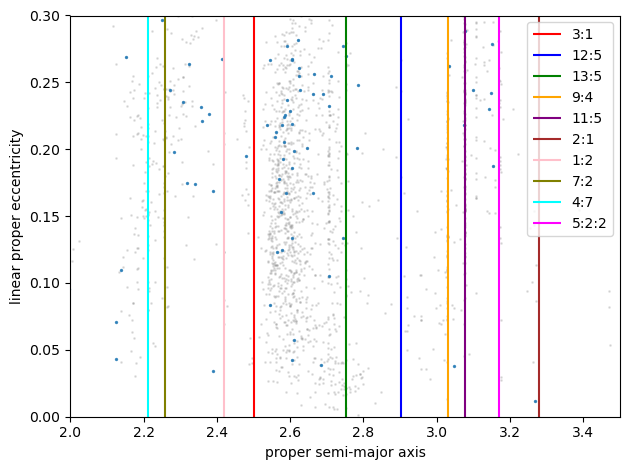

In [60]:
colors = [
    "red", "blue", "green", "orange", "purple", "brown",
    "pink", "olive", "cyan", "magenta"
]
merged_df_high = merged_df[merged_df['d'] > 100]
linear_prop_e = merged_df_high['prope_h']
a = merged_df_high['propa']
plt.scatter(a, linear_prop_e, s = 1, alpha = 0.2, color = "grey")
plt.scatter(high_error_asteroids['propa'], high_error_asteroids['prope_h'], alpha = 0.8, s = 2)
for (label, a_val), color in zip(a_values.items(), colors):
    plt.vlines(a_val, 0, 0.3, label = label, color = color)
plt.ylim(0, 0.3)
plt.xlim(2, 3.5)
plt.xlabel("proper semi-major axis")
plt.ylabel("linear proper eccentricity")
plt.legend()
plt.tight_layout()
plt.show()

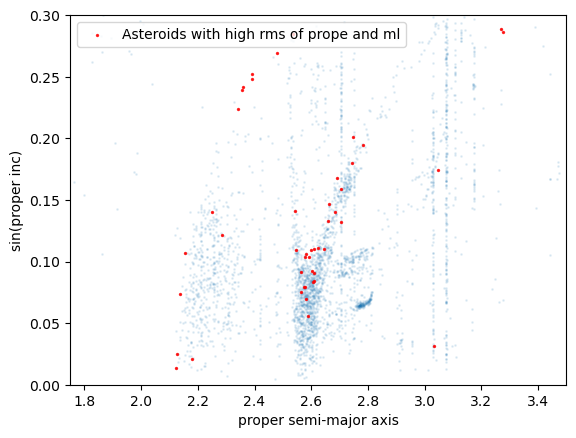

In [62]:
merged_df_high = merged_df[merged_df['d'] > 50]
linear_prop_inc = np.sin(merged_df_high['propsini'])
a = merged_df_high['propa']
plt. scatter(a, linear_prop_inc, s = 1, alpha = 0.1)
plt.scatter(high_error_asteroids['propa'], np.sin(high_error_asteroids['propsini']), color = 'red', alpha = 0.8, s = 2, label = "Asteroids with high rms of prope and ml")
plt.ylim(0, 0.3)
plt.xlim(1.75, 3.5)
# for (label, a_val), color in zip(a_values.items(), colors):
#     plt.vlines(a_val, 0, 0.3, label = label, color = color)
plt.xlabel("proper semi-major axis")
plt.ylabel("sin(proper inc)")
plt.legend()

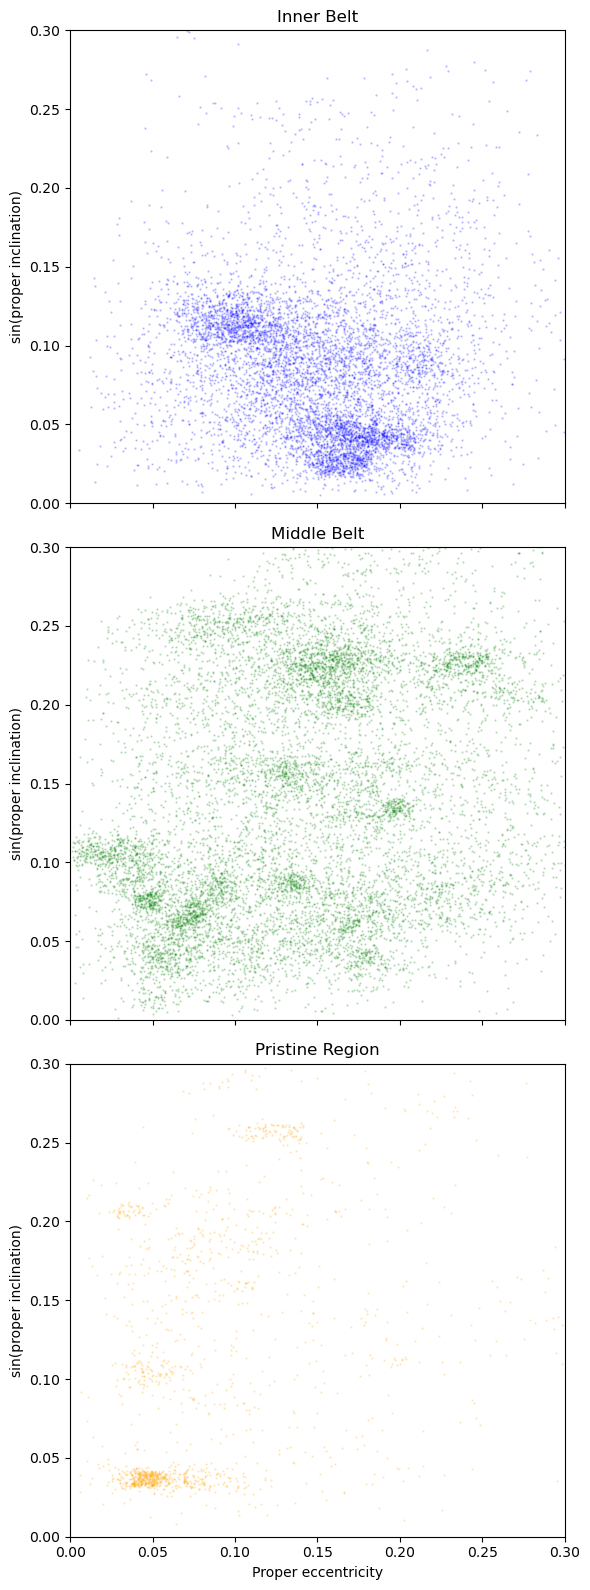

In [57]:
import matplotlib.pyplot as plt
import numpy as np

inner_belt_df = merged_df[merged_df["propa"] < 2.5]
middle_belt_df = merged_df[(merged_df["propa"] > 2.5) & (merged_df["propa"] < 2.825)]
pristine_df = merged_df[(merged_df["propa"] > 2.825) & (merged_df["propa"] < 2.958)]

fig, ax = plt.subplots(3, 1, figsize=(6, 16), sharex=True, sharey=True)

# Inner belt
linear_sin_i_inner = np.sin(inner_belt_df['propsini_h'])
linear_prope_inner = inner_belt_df["prope_h"]
ax[0].scatter(linear_prope_inner, linear_sin_i_inner, s=0.5, alpha=0.2, color='blue')
ax[0].set_title("Inner Belt")

# Middle belt
linear_sin_i_middle = np.sin(middle_belt_df['propsini_h'])
linear_prope_middle = middle_belt_df["prope_h"]
ax[1].scatter(linear_prope_middle, linear_sin_i_middle, s=0.5, alpha=0.2, color='green')
ax[1].set_title("Middle Belt")

# Pristine region
linear_sin_i_pristine = np.sin(pristine_df['propsini_h'])
linear_prope_pristine = pristine_df["prope_h"]
ax[2].scatter(linear_prope_pristine, linear_sin_i_pristine, s=0.5, alpha=0.2, color='orange')
ax[2].set_title("Pristine Region")

for axis in ax:
    axis.set_xlim(0, 0.3)
    axis.set_ylim(0, 0.3)
    axis.set_ylabel("sin(proper inclination)")

ax[2].set_xlabel("Proper eccentricity")

plt.tight_layout()
plt.show()

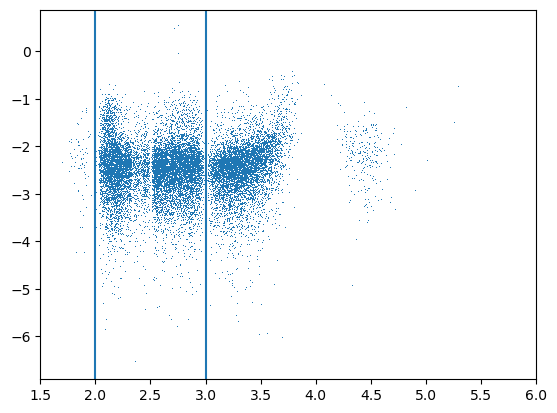

In [ ]:
aJup = 5.202263784717109
fig, ax = plt.subplots()
ax.plot((aJup/testX['propa'])**(3/2), np.log10(np.abs(pred-testY)), ',')
ax.set_xlim([1.5, 6])
ax.axvline(2)
ax.axvline(3)

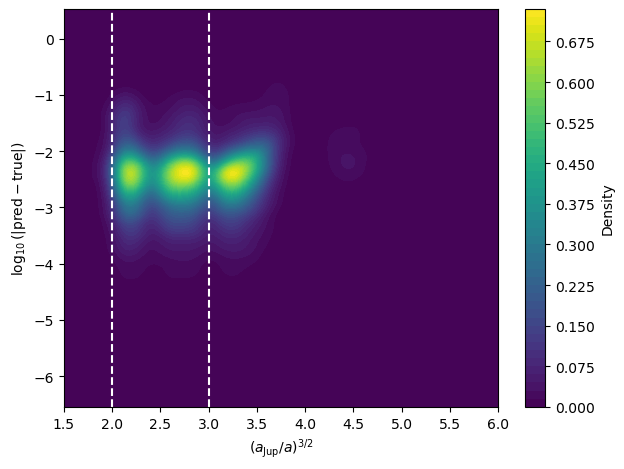

In [ ]:
from scipy.stats import gaussian_kde

# Compute your X and Y data
x = (aJup / testX['propa'])**(3/2)
y = np.log10(np.abs(pred - testY))

# Stack the data for KDE
xy = np.vstack([x, y])
kde = gaussian_kde(xy)

# Create a grid over the plot range
xgrid = np.linspace(1.5, 6, 200)
ygrid = np.linspace(np.min(y), np.max(y), 200)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde(np.vstack([Xgrid.ravel(), Ygrid.ravel()])).reshape(Xgrid.shape)

# Plot
fig, ax = plt.subplots()
contour = ax.contourf(Xgrid, Ygrid, Z, levels=50, cmap='viridis')
ax.set_xlim([1.5, 6])
ax.axvline(2, color='white', linestyle='--')
ax.axvline(3, color='white', linestyle='--')
fig.colorbar(contour, ax=ax, label='Density')
ax.set_xlabel(r'$(a_\mathrm{Jup} / a)^{3/2}$')
ax.set_ylabel(r'$\log_{10}(|\mathrm{pred} - \mathrm{true}|)$')
plt.tight_layout()
plt.show()